In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import unicodedata
import contractions
import inflect
import os
import timeit
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from tensorflow.python.keras.preprocessing.text import Tokenizer as k_tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, Model
from tqdm import tqdm
from collections import OrderedDict

[nltk_data] Downloading package stopwords to /Users/arwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Loading the data
df_1 = pd.DataFrame()
df_1 = pd.read_csv('Data/Black Lives Matters.csv',
                       encoding='latin-1',
                       names=["Date", "Time", "Timezone", "Tweet", "Hashtag"])
df_2 = pd.DataFrame()
df_2 = pd.read_csv('Data/Blacklivematter.csv',
                       encoding='latin-1',
                       names=["Date", "Time", "Timezone", "Tweet", "Hashtag"])
df_3 = pd.DataFrame()
df_3 = pd.read_csv('Data/blacklivesmatter.csv',
                       encoding='latin-1',
                       names=["Date", "Time", "Timezone", "Tweet", "Hashtag"])
df_4 = pd.DataFrame()
df_4 = pd.read_csv('Data/Breonna Taylor.csv',
                       encoding='latin-1',
                       names=["Date", "Time", "Timezone", "Tweet", "Hashtag"])
df_5 = pd.DataFrame()
df_5 = pd.read_csv('Data/George Floyd.csv',
                       encoding='latin-1',
                       names=["Date", "Time", "Timezone", "Tweet", "Hashtag"])
df_1 = df_1.iloc[1:]
df_2 = df_2.iloc[1:]
df_3 = df_3.iloc[1:]
df_4 = df_4.iloc[1:]
df_5 = df_5.iloc[1:]

frames = [df_1, df_2, df_3, df_4, df_5]
all_df = pd.concat(frames, ignore_index=True)

all_df.head()

/Users/arwan/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Timezone,Tweet,Hashtag
0,2019-12-29,22:47:29,+0200,Black people get death sentences for just bein...,['blacklivesmatters']
1,2019-12-29,21:33:35,+0200,@JDsBunker @TheBahamutAli @shreyabasu003 @90sS...,[]
2,2019-12-29,20:27:56,+0200,@Slutypancake @geoff150 @ava @AlexSilverman @H...,[]
3,2019-12-29,20:18:39,+0200,@datdannydoe Ugh that's so annoying! ð Ther...,[]
4,2019-12-29,19:38:20,+0200,@digitaldutta What exemptions is it claiming? ...,['blacklivesmatters']


In [5]:
# Data normalization
def clean_tweet(sentence):
#     new_words = []
#     str1 = " "
#     for word in sentence.split():
#         # Remove or convert non-ASCII characters
#         new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#         # Remove stopwords
#         if new_word not in stopwords.words('english'):
#             new_words.append(new_word)
#     sentence = (str1.join(new_words))
    
    # Removing URLs
    sentence = re.sub(r"http\S+", "", sentence)
    
    # Replace contractions
    sentence = contractions.fix(sentence)
    
    # Remove punctuations (emojis, '@', '#', etc...)
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Replace numbers by their string using inflect
#     p = inflect.engine()
#     new_words = []
#     for word in sentence.split():
#         if word.isdigit():
#             try:
#                 new_word = p.number_to_words(word)
#                 new_words.append(new_word)
#             except:
#                 pass
#         else:
#             new_words.append(word)
#     str1 = " "
#     sentence = (str1.join(new_words))

    # Remove isolated number that weren't replaces
    sentence = re.sub("\\b[0-9]+\\b", "", sentence)
    
    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Remove stop-words (usualy common words under 3 letters that don't add any info)
#     new_words = []
#     for word in sentence.split():
#         if word not in stopwords.words('english'):
#             new_words.append(word)
#     str1 = " "
#     sentence = (str1.join(new_words))
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercasing
    sentence = sentence.lower()
    
    return sentence

# Example
example_1 = "http://bbc.in/1BO3eWQ Check it quickly héhé ! 网络 This isn't a test. I got 10 good answers! :) #LOL @brian"
print(clean_tweet(example_1))

 check quickly hehe this test got good answers lol brian


In [7]:
# Look for the part that takes so much time

code_1 = """
import unicodedata

new_words = []
for word in sentence.split():
    # Remove or convert non-ASCII characters
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove stopwords
    if new_word not in stopwords.words('english'):
        new_words.append(new_word)
        str1 = " "
sentence = (str1.join(new_words))
"""

code_2 = """
# Removing URLs
sentence = re.sub(r"http\S+", "", sentence)
"""

code_3 = """
import contractions
# Replace contractions
sentence = contractions.fix(sentence)
"""

code_4 = """
# Remove punctuations (emojis, '@', '#', etc...)
sentence = re.sub(r'[^\w\s]', '', sentence)
"""

code_5 = """
# Remove isolated number that weren't replaces
sentence = re.sub("\\b[0-9]+\\b", "", sentence)
"""

code_6 = """
# Remove single characters
sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
"""

code_7 = """
# Removing multiple spaces
sentence = re.sub(r'\s+', ' ', sentence)
"""

code_8 = """
sentence = sentence.lower()
"""
sentence = example_1
codes = [code_1, code_2, code_3, code_4, code_5, code_6, code_7, code_8]
nb_tests = 1000
for code in codes:
    elapsed_time = timeit.timeit(code, number=nb_tests, setup="from __main__ import stopwords, sentence, re")
    print(elapsed_time)


3.336453794999997
0.001347367999997573
0.010124535000002766
0.0030098100000088834
0.0015273380000024872
0.0072410470000079385
0.01045756900001038
0.0011392480000012029


In [8]:
# Normalize the data
tweets = all_df.loc[:, 'Tweet'].values
tweets = [clean_tweet(tweet) for tweet in tqdm(tweets)]

100%|██████████| 1513356/1513356 [2:21:35<00:00, 178.13it/s]  


In [9]:
# Save cleaned tweets
with open('normalized_tweets.txt', 'w+') as f:
    for tweet in tweets:
        f.write("%s\n" % tweet)
# Load saved cleaned tweets
# my_file = open("normalized_tweets.txt", "r")
# content = my_file.readlines()
# tweets = [float(x[:-2]) for x in content]

In [10]:
# Tokenize and vectorize the data
tokenizer = k_tokenizer()
tokenizer.fit_on_texts(tweets)
tweets_tokens = tokenizer.texts_to_sequences(tweets)

In [38]:
max_sequence = 400
# Crop tweets that are too long (>400)
tweets_croped = [tweet[:max_sequence-1] for tweet in tweets_tokens]
# Remove indexes that are unknown
for i in tqdm(range(len(tweets_croped))):
    for j in range(len(tweets_croped[i])):
        if tweets_croped[i][j] >= 266370:
             tweets_croped[i][j] = 0
tweets_padded = pad_sequences(tweets_croped, maxlen=max_sequence, padding='post')

100%|██████████| 1513356/1513356 [00:09<00:00, 162299.01it/s]


In [12]:
# Load the model
model = load_model('models/conv_dense_k=1,2,3_model.hdf5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [39]:
# Compute predictions
res = model.predict(tweets_padded, verbose=1)
res = res.flatten().tolist()

1513356/1513356 [==============================] - 739s 488us/step


In [40]:
# Save predictions in a txt file

with open('results_1.txt', 'w+') as f:
    for item in res:
        f.write("%s\n" % item)

In [ ]:
# Load predictions from a txt file

# my_file = open("results_1.txt", "r")
# content = my_file.readlines()
# res = [float(x[:-2]) for x in content]

In [41]:
# Link dates to predictions
storage = {}
for i in tqdm(range(len(res))):
    today = all_df.iloc[i]['Date']
    if today not in storage:
        storage[today] = [res[i]]
    else:
        storage[today].append(res[i])

100%|██████████| 1513356/1513356 [03:24<00:00, 7410.61it/s]


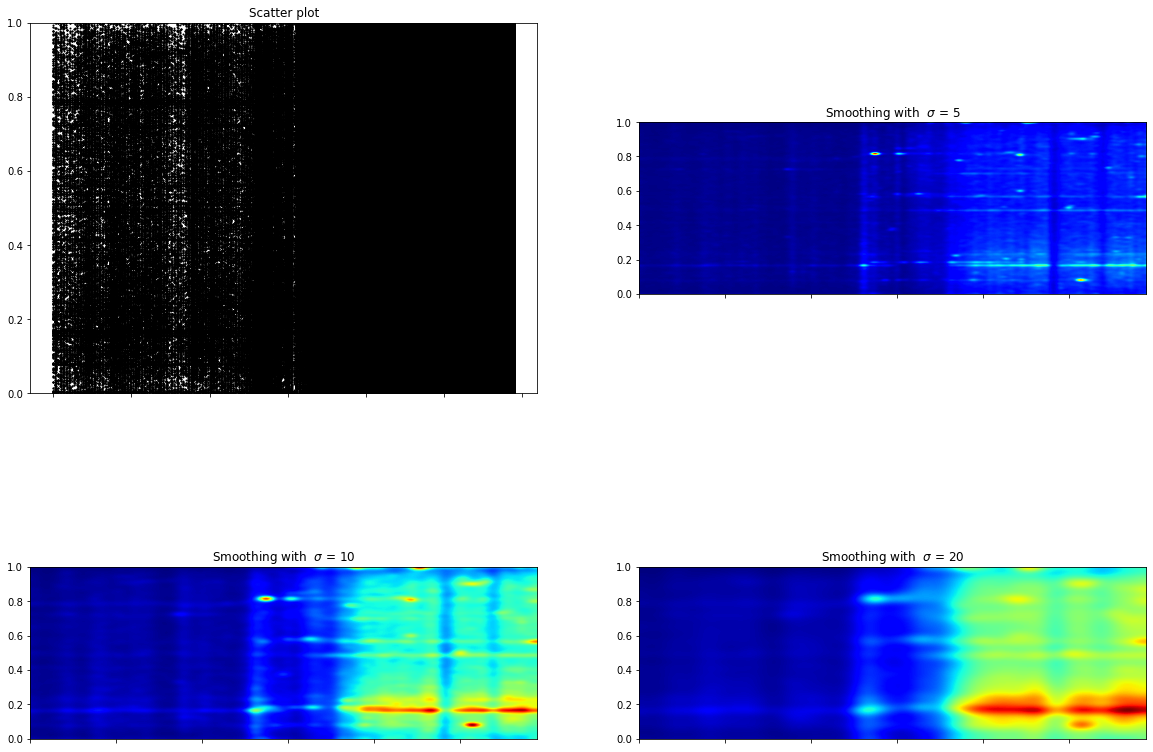

In [58]:
# Order tweets in chronological order
ordered_storage = OrderedDict(sorted(storage.items(), key=lambda t: t[0]))

# Retrieve prediction values
predictions = list(ordered_storage.values())

# Prepare lists for heatmap
y_ax = []
cpt = 0
for elem in predictions:
    y_ax.append([cpt]*len(elem))
    cpt += 0.01 
pred_flat = sum(predictions, [])
y_flat = sum(y_ax, [])

# Plot heatmap
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, axs = plt.subplots(2, 2, figsize=(20,15))
# sigmas = [0, 1, 3, 5]
sigmas = [0, 5, 10, 20]

for ax, s in zip(axs.flatten(), sigmas):
    ax.set_ylim([0, 1])
    if s == 0:
        ax.plot(y_flat, pred_flat, 'k.', markersize=2)
        ax.set_title("Scatter plot")
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        img, extent = myplot(y_flat, pred_flat, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)
        ax.xaxis.set_major_formatter(plt.NullFormatter())

# plt.savefig('sentiment_heatmap.png', dpi=400)
plt.show()